In [1]:
import re
import html
import pandas as pd
import numpy as np
import spacy
from string import punctuation
from math import sqrt, ceil
# gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm import tqdm
tqdm.pandas()

#### Import custom text preprocessing class for this exercise
For this dataset, the class `Textpreprocessor` is defined in the file `custom_preprocessing.py`.

In [2]:
from custom_preprocessing import TextPreprocessor

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [3]:
data_path = "../data/nytimes.tsv"

df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['date', 'headline', 'content'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [4]:
df1 = df.iloc[:2000, :].copy()
# df1 = df.copy()

#### Include some extra words to remove from article text
Some unnecessary worsd show up in the article text that also need to be added to the default stopword list.

In [5]:
extra_words = ['-pron-', 'mr', 'mrs', 'ms', 'dr', 'million']
removed_words = set(punctuation).union(set(extra_words))

#### Call TextProcessor class
Clean up the text content for the topic model. Stopword removal and lemmatization are done as well. 

In [6]:
preproc = TextPreprocessor()
df1['lemmas'] = df1['content'].progress_apply(
                lambda text: preproc.lemmatize(text, removed_words)
                )

100%|██████████| 2000/2000 [00:15<00:00, 130.72it/s]


In [7]:
df1.head(3)

,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitch, keep, mets, afloat, half, sea..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, de, blasios, counsel, chief, leg..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, morning, hour, labor, day, year, group..."


### Build LDA Model

#### Serial LDA algorithm

In [8]:
def run_lda(text_df, num_topics, iterations=200, epochs=20):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 5% of documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=0.05, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaModel(
       corpus=corpus,
       id2word=id2word,
       num_topics=num_topics,
       alpha='auto',
       eta='auto',
       random_state=1,
       chunksize=2048,
       passes=epochs,
       iterations=iterations,
    )
    return lda_model

#### Multicore LDA algorithm

In [9]:
# Choose number of workers for multicore LDA as (num_physical_cores - 1)
def run_lda_multicore(text_df, num_topics, iterations=200, epochs=20, workers=7):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 2% documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=0.02, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaMulticore(
       corpus=corpus,
       id2word=id2word,
       workers=workers,
       num_topics=num_topics,
       random_state=1,
       chunksize=2048,
       passes=epochs,
       iterations=iterations,
    )
    return lda_model, corpus

### Wordclouds of most likely words in each topic

In [10]:
def plot_wordclouds(topics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                      width=1000,
                      height=800,
                      colormap='cividis',
                     )
    # Define the size of the subplot matrix as a function of num_topics
    dim = ceil(sqrt(len(topics)))
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(len(topics)):
        print("Topic {}".format(i+1))
        ax = fig.add_subplot(dim, dim, i+1) 
        topic_words = dict(topics[i][1])
        wordcloud = cloud.generate_from_frequencies(topic_words)
        ax.imshow(wordcloud)
        ax.set_title('Topic {}'.format(i+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.subplots_adjust(wspace=0, hspace=0);
    plt.margins(x=0, y=0);
    plt.tight_layout();

### Run topic model and plot wordclouds

In [11]:
num_topics = 10
iterations = 200
epochs=20

model, corpus = run_lda_multicore(df1, num_topics=num_topics, iterations=iterations, epochs=epochs)

Topic 1
Topic 2
Topic 3
Topic 4
Topic 5
Topic 6
Topic 7
Topic 8
Topic 9
Topic 10


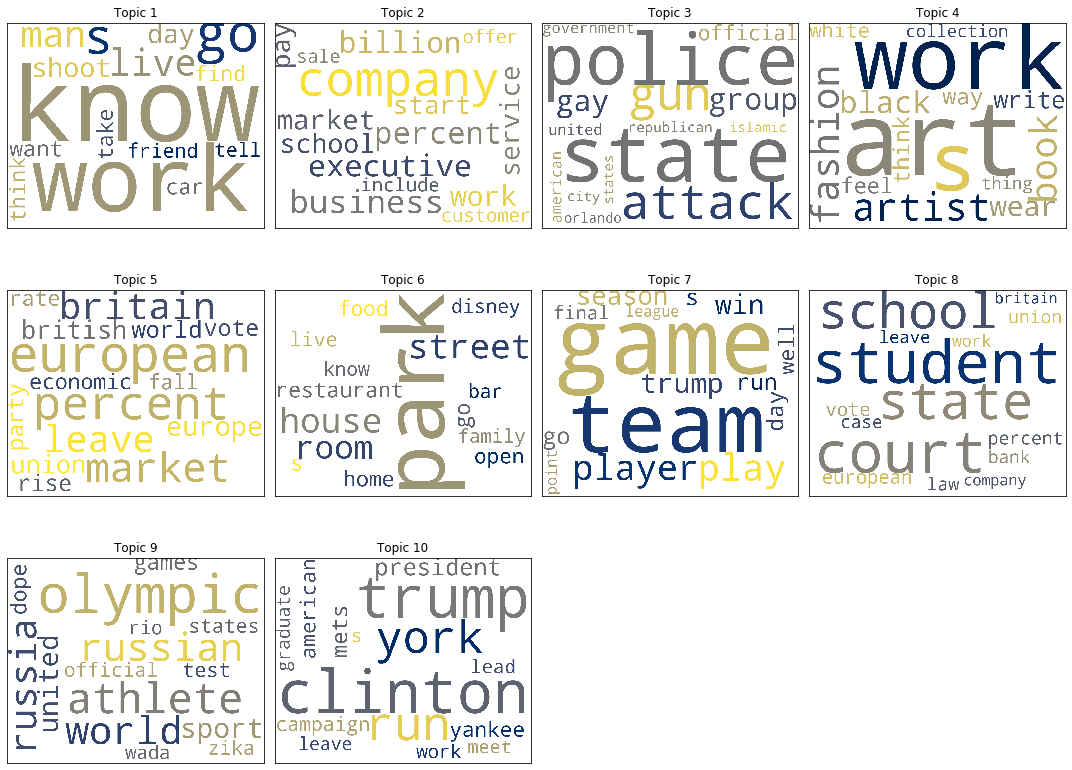

In [12]:
plot_wordclouds(model.show_topics(formatted=False, num_topics=num_topics, num_words=15))

### Obtain topic distribution per document

In [13]:
topic_dist = model.get_document_topics(corpus, minimum_probability=0.0)
len(topic_dist)

2000

In [14]:
# First throw away first item (topic ID) in tuple by unpacking...
# Then recast to a list of topic weights per document
distribution = [list(zip(*item))[1] for item in topic_dist]
distribution = pd.Series([list(item) for item in distribution])

#### Create DataFrame containing dominant topics and the topic distribution per document

In [15]:
dominantTopicsDF = pd.concat([df1[['date', 'lemmas']], distribution],
                             axis=1)
dominantTopicsDF.columns = ['date', 'lemmas', 'topicDistribution']
dominantTopicsDF.head()

,date,lemmas,topicDistribution
0,2016-06-30,"[stellar, pitch, keep, mets, afloat, half, sea...","[0.0002613965, 0.00026138744, 0.00026138462, 0..."
1,2016-06-30,"[mayor, bill, de, blasios, counsel, chief, leg...","[0.06853246, 0.00036866302, 0.72070074, 0.0003..."
2,2016-06-30,"[early, morning, hour, labor, day, year, group...","[0.20432417, 0.0002790735, 0.55814296, 0.00027..."
3,2016-06-30,"[apple, store, new, york, city, thing, apple, ...","[0.00032015645, 0.49841276, 0.00032012968, 0.0..."
4,2016-06-30,"[united, states, olympic, swim, trial, spectac...","[0.00023122887, 0.00023122421, 0.00023122193, ..."


In [18]:
def get_dominant_topics_ids(topic_weights):
    topic_weights = np.array(topic_weights)
    topic_ids = topic_weights.argsort()[-len(topic_weights):][::-1]
    topic_ids += 1    # Increment by one to avoid zero-indexing topics
    return topic_ids

In [19]:
dominantTopicsDF['dominantTopics'] = dominantTopicsDF['topicDistribution'].progress_apply(get_dominant_topics_ids)
dominantTopicsDF.head()

100%|██████████| 2000/2000 [00:00<00:00, 76060.24it/s]


,date,lemmas,topicDistribution,dominantTopics
0,2016-06-30,"[stellar, pitch, keep, mets, afloat, half, sea...","[0.0002613965, 0.00026138744, 0.00026138462, 0...","[10, 7, 1, 5, 6, 4, 2, 9, 8, 3]"
1,2016-06-30,"[mayor, bill, de, blasios, counsel, chief, leg...","[0.06853246, 0.00036866302, 0.72070074, 0.0003...","[3, 8, 1, 9, 4, 10, 2, 7, 6, 5]"
2,2016-06-30,"[early, morning, hour, labor, day, year, group...","[0.20432417, 0.0002790735, 0.55814296, 0.00027...","[3, 7, 1, 6, 10, 2, 9, 8, 4, 5]"
3,2016-06-30,"[apple, store, new, york, city, thing, apple, ...","[0.00032015645, 0.49841276, 0.00032012968, 0.0...","[2, 8, 6, 4, 1, 5, 7, 3, 10, 9]"
4,2016-06-30,"[united, states, olympic, swim, trial, spectac...","[0.00023122887, 0.00023122421, 0.00023122193, ...","[9, 7, 6, 4, 1, 5, 10, 2, 8, 3]"
